In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# === Load a memory-safe chunk of the preprocessed data ===
chunks = []
for chunk in pd.read_csv("all_stocks_index_1min_preprocess.csv", chunksize=100_000):
    chunks.append(chunk)
    if len(chunks) == 3:  # Change 3 to load more or less data
        break

df = pd.concat(chunks, ignore_index=True)

# === Define Features ===
features = ['open', 'high', 'low', 'close', 'volume',
            'SMA_10', 'EMA_9', 'EMA_21', 'RSI_14', 'MA_20',
            'BB_Upper', 'BB_Lower', 'EMA_12', 'EMA_26',
            'MACD', 'Signal_Line', '%K', '%D', 'ATR_14']

# Drop rows with NaNs (if any)
df = df[features].dropna()

# === Scale the Features ===
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_data, columns=features)

# === Prepare Target (Next Minute's Close Price) ===
target = df['close'].shift(-1).values[:-1]
scaled_df = scaled_df[:-1]  # Drop last row to match target

# === Sequence Preparation Function ===
def create_sequences(data, target, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(target[i+time_steps])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_df.values, target, time_steps=60)

# === Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# === Define LSTM Model ===
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# === Train the Model ===
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1)

# === Evaluate the Model ===
loss = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {loss:.4f}")


c:\Users\VIBHANSHU JAIN\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 138s 40ms/step - loss: 3.0852e-04 - val_loss: 8.7282e-07
Epoch 2/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 131s 39ms/step - loss: 2.8081e-06 - val_loss: 1.9475e-07
Epoch 3/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 135s 40ms/step - loss: 1.7404e-06 - val_loss: 2.2734e-06
Epoch 4/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 132s 39ms/step - loss: 1.2993e-06 - val_loss: 2.7638e-07
Epoch 5/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 129s 38ms/step - loss: 1.0117e-06 - val_loss: 5.6770e-07
Epoch 6/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 129s 38ms/step - loss: 9.9827e-07 - val_loss: 1.9869e-08
Epoch 7/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 130s 39ms/step - loss: 9.6148e-07 - val_loss: 1.0478e-07
Epoch 8/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 129s 38ms/step - loss: 9.5961e-07 - val_loss: 8.3163e-08
Epoch 9/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 160s 48ms/step - loss: 9.5012e-07 - val_loss: 4.2773e-07
Epoch 10/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 218s 65ms/step - loss: 9.3275e-07 - val_loss: 5.3349e-07
1875/1875

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step


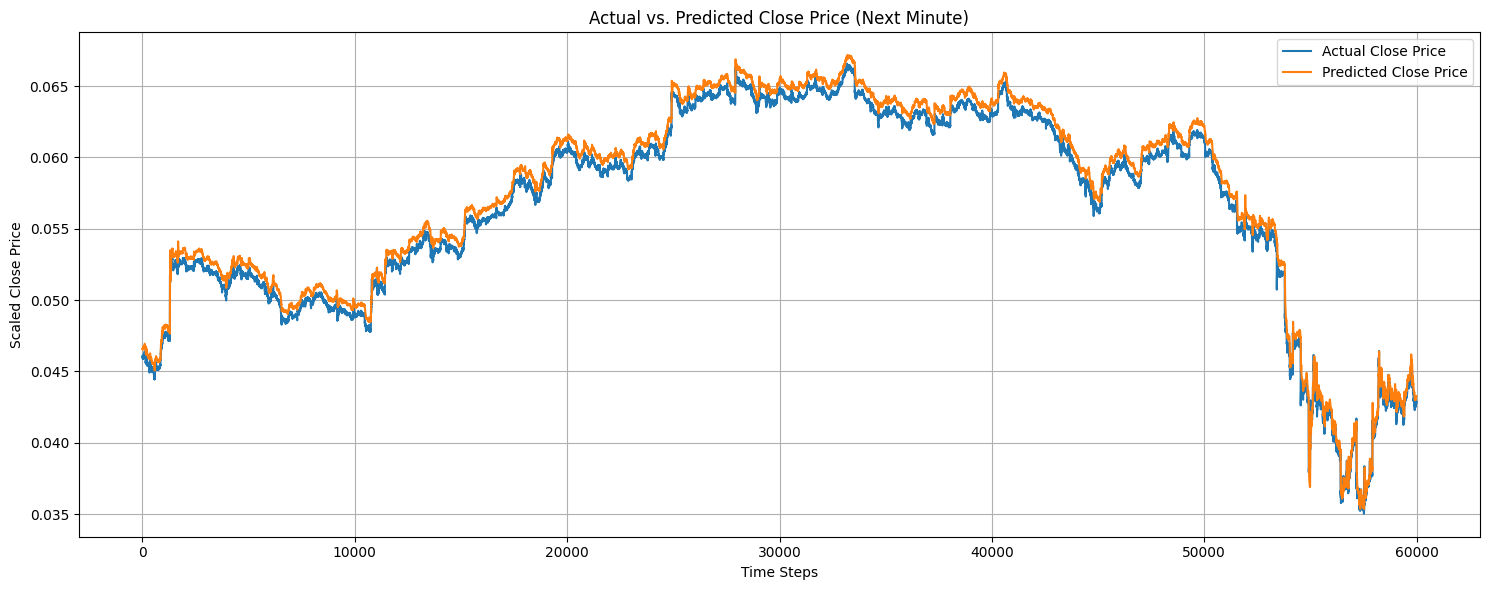

In [2]:
import matplotlib.pyplot as plt

# === Make Predictions ===
y_pred = model.predict(X_test)

# === Plot Actual vs. Predicted Close Prices ===
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='Actual Close Price')
plt.plot(y_pred, label='Predicted Close Price')
plt.title('Actual vs. Predicted Close Price (Next Minute)')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Make predictions
y_pred = model.predict(X_test).flatten()

# Calculate metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step
R2 Score: 0.9887
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0007


In [8]:
model.save("lstm_stock_model.keras")

In [2]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("lstm_stock_model.keras")

# Optionally, check the model architecture
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,861 (397.90 KB)

 Trainable params: 33,953 (132.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 67,908 (265.27 KB)

In [4]:
from sklearn.metrics import r2_score

# Predict on test set
y_pred = model.predict(X_test)

# Calculate R² score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step
R² Score: 0.9887
